In [2]:
import librosa
import pandas as pd
from librosa.effects import pitch_shift
import os
from sklearn.metrics import classification_report
import pathlib
import random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from librosa.feature import mfcc, melspectrogram
import scipy.io.wavfile as wav
import tensorflow as tf
import scipy.signal as signal
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from research.dataImporting import MLtools
from keras.optimizers import adam_v2
from keras.layers import Input, Conv1D, Conv2D, Conv3D,SeparableConv1D, MaxPooling1D,MaxPooling2D,MaxPooling3D, Flatten, Dense, Dropout, \
    BatchNormalization, Activation, LSTM, Lambda, Reshape, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from research.dataImporting import dataTools
import keras.backend as K
from tcn import TCN
from keras import regularizers

In [6]:
training_df_raw=pd.read_csv("datasets/0.5_raw_range_A1_A2_A3_no_overlap_v2.csv",index_col=0)

In [9]:
phone_slots=["Phone_6-2","Phone_29","Phone_8","Phone_2-4","Phone_1-1","Phone_12","Phone_6-3","Phone_27","Phone_7-1","Phone_5-4","Phone_2-3","Phone_3-1","Phone_15","Phone_10","Phone_1-3","Phone_6-4","Phone_28","Phone_3-5","Phone_3-4","Phone_3-2","Phone_2-5","Phone_5-3","Phone_30","Phone_6-5","Phone_11","Phone_5-2","Phone_9","Phone_7-2"]

cluster_1=["Phone_6-2","Phone_29","Phone_8","Phone_2-4","Phone_1-1","Phone_12","Phone_6-3","Phone_27"]
cluster_2=["Phone_7-1","Phone_5-4","Phone_2-3","Phone_3-1","Phone_15","Phone_10","Phone_1-3","Phone_6-4"]
cluster_3=["Phone_28","Phone_3-5","Phone_3-4","Phone_3-2","Phone_2-5","Phone_5-3","Phone_30","Phone_6-5","Phone_11","Phone_5-2","Phone_9","Phone_7-2"]

bad_runs=["A3R6P1","A3R4P4","A3R4P5","A3R3P4","A3R3P5","A2R1P3"]
good_runs_IF=["A1R1P1","A1R1P2","A1R1P3","A1R1P4","A1R1P5","A2R1P1","A2R1P2","A2R1P3","A2R1P4","A2R1P5","A2R2P1","A2R2P2","A2R2P3","A2R2P4","A2R2P5"]
good_runs_matrice=["A1R2P2","A1R2P","A1R2P4","A1R2P5","A2R3P1","A2R3P2","A2R4P1","A2R4P2","A2R4P3","A3R3P1","A3R3P2","A3R4P2","A3R4P3","A3R4P5"]
good_runs_phantom=["A2R5P1","A2R5P2","A2R5P3","A2R5P4","A2R5P5","A2R6P1","A2R6P2","A2R6P3","A2R6P4","A2R6P5","A3R5P1","A3R5P2","A3R5P3","A3R5P4","A3R6P1","A3R6P2","A3R6P3","A3R6P4"]
test_runs_matrice=["A2R3P3","A3R3P3"]
notable_col_names=['Pass','Segment','Phone','Lat','Lon','Alt','Range']
parent_directory=os.path.abspath(os.path.join(os.getcwd(), ".."))
passes_df=pd.read_csv(parent_directory+"\\flight_directories\\A1_A2_A3_training_w_Matrice_Phantom.csv")
x_data=[]
y_data=[]
def melspect(audioData, Fs):
    '''
    Converts decoded wav file to MFCC feature space
    @param audioData: Numpy array of decoded audio wav file
    @return MFCC coefficients
    '''
    data= audioData.astype(float)
    # spect = melspectrogram(y=data,sr=Fs, hop_length=1024,n_mels=64, n_fft=2048)
    spect = melspectrogram(y=data,sr=Fs)
    return spect
x_data=[]
y_data=[]
thd_frame=[]
range_frame=[]
for x in passes_df.iterrows():
    row=x[1]
    pass_num=row[0]
    scenario=row[1]
    run_num=row[2]
    start=row[3]
    stop=row[4]
    drone_gps_file=row[5]
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
    pass_df=training_df_raw.loc[training_df_raw[str(notable_col_names.index('Pass'))] == full_name]
    #pass_df=training_df.loc[training_df["Pass"] == full_name]
    max_segment=pass_df[str(notable_col_names.index('Segment'))].max()
    #max_segment=pass_df["Segment"].max()
    #for i in range(0,max_segment):
    print(full_name)
    if full_name in good_runs_IF:
        drone_type=1
    elif full_name in good_runs_matrice:
        drone_type=0
    else:
        drone_type=2
    if full_name in good_runs_matrice or full_name in good_runs_IF or full_name in good_runs_phantom:
    #if full_name == "A2R1P3":
        for i in range(0,max_segment):
            clust_1=[]
            clust_2=[]
            clust_3=[]
            frame_df=pass_df.loc[pass_df[str(notable_col_names.index('Segment'))]==i]
            if len(frame_df != 0):
                thd_frame=[]
                range_frame=[]
                for phone in phone_slots:
                    if phone in cluster_1:
                        cluster=1
                    elif phone in cluster_2:
                        cluster=2
                    elif phone in cluster_3:
                        cluster=3
                #for i in range(0,max_segment):
                    #frame_df=phone_seg.loc[phone_seg[str(notable_col_names.index('Segment'))]==i]
                    phone_seg=frame_df.loc[frame_df[str(notable_col_names.index('Phone'))]==phone]
                #phone_seg=frame_df.loc[frame_df["Name"]==phone]
                    data=np.array(phone_seg.iloc[:,8:4008])
                    #data=np.array(frame_df.iloc[:,8:16008])
                    if np.any(data):
                        mel_data=melspect(data[0],8000)
                    else:
                        mel_data=np.zeros((128,8))
                #data=np.array(frame_df.iloc[:,-512:])
                # dist=phone_seg[str(notable_col_names.index('Range'))]
                    dist=phone_seg[str(notable_col_names.index('Range'))]
                #dist=phone_seg["Range"]
                    if len(np.array(dist)>0):
                            data=data[0]
                            #data=np.reshape(data,(64,4))
                            #data=np.reshape(data,(40,1))
                            dist=np.array(dist)[0]
                            if phone in cluster_1:
                                clust_1.append(dist)
                            elif phone in cluster_2:
                                clust_2.append(dist)
                            elif phone in cluster_3:
                                clust_3.append(dist)
                    thd_frame.append(mel_data)
                #print(np.average(np.array(clust_1)),np.average(np.array(clust_2)),np.average(np.array(clust_3)))
                # range_frame.append([class_value,drone_type,dist])
                range_frame=np.argmin([np.average(np.array(clust_1)),np.average(np.array(clust_2)),np.average(np.array(clust_3))])
            #y_vals= rangeClosest(range_frame)
                x_data.append(np.array(thd_frame))
                y_data.append(range_frame)

A1R2P1
A1R2P2
A1R2P3
A1R2P4
A1R2P5
A2R3P1
A2R3P2
A2R3P3
A2R4P1
A2R4P2
A2R4P3
A2R5P1
A2R5P2
A2R5P3
A2R5P4
A2R5P5
A2R6P1
A2R6P2
A2R6P3
A2R6P4
A2R6P5
A3R3P1
A3R3P4
A3R3P5
A3R4P4
A3R4P5
A3R6P1


In [10]:
x_data=np.array(x_data)
x_data=np.float32(x_data)
y_data=np.array(y_data)
train_feats,test_feats,train_targs,test_targs=train_test_split(x_data,y_data,test_size=0.2,shuffle=True,random_state=42)

Text(0, 0.5, 'Count')

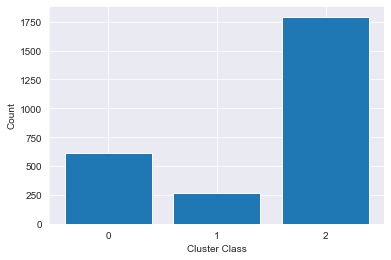

In [11]:
# plt.hist(y_data)

# plt.xticks((0,2,1),align='center')
labels, counts = np.unique(y_data, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.xlabel("Cluster Class")
plt.ylabel("Count")
#plt.savefig("./Plots/earlyDF_distro.pdf")

In [12]:
from sklearn.utils import class_weight
# class_weights=class_weight.compute_class_weight('balanced', classes=np.unique(class_train_targs), y=class_train_targs)
# class_weights={0:class_weights[0], 1:class_weights[1]}
#print(class_weights)
range_weights=class_weight.compute_class_weight('balanced', classes=np.unique(train_targs), y=train_targs)
#,4:range_weights[4],5:range_weights[5], 6:range_weights[6]
range_weights={0:range_weights[0], 1:range_weights[1],2:range_weights[2]}
print(range_weights)

{0: 1.431254191817572, 1: 3.2333333333333334, 2: 0.5019995295224653}


In [13]:
modelCNN_MCV2=tf.keras.Sequential()
modelCNN_MCV2.add(BatchNormalization(input_shape=(28,128,8)))
modelCNN_MCV2.add(Conv2D(filters=8,kernel_size=(3,3),strides=(1,1),padding='SAME', use_bias=False, name='conv_1'))
modelCNN_MCV2.add(BatchNormalization())
modelCNN_MCV2.add(Activation('leaky_relu'))
modelCNN_MCV2.add(MaxPooling2D(2))
modelCNN_MCV2.add(Conv2D(filters=16,kernel_size=(3,3),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_2'))
modelCNN_MCV2.add(BatchNormalization())
modelCNN_MCV2.add(Activation('leaky_relu'))
modelCNN_MCV2.add(Dropout(0.3))
modelCNN_MCV2.add(Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_3'))
modelCNN_MCV2.add(BatchNormalization())
modelCNN_MCV2.add(Activation('leaky_relu'))
modelCNN_MCV2.add(Dropout(0.3))
modelCNN_MCV2.add(Flatten())
modelCNN_MCV2.add(Dense(256, activation='leaky_relu', name='dense_2'))
modelCNN_MCV2.add(Dense(128, activation='leaky_relu', name='dense_3'))
modelCNN_MCV2.add(Dropout(0.5))
modelCNN_MCV2.add(Dense(3, activation='softmax', name='output_range'))
optimizer= tf.keras.optimizers.Adam()
modelCNN_MCV2.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])


reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 verbose=1, patience=20, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=40, mode='auto', restore_best_weights=True)
modelCNN_MCV2.build(input_shape=(None,128,8,1))
modelCNN_MCV2.summary()
single_drone_train_targs_oh=tf.keras.utils.to_categorical(train_targs,num_classes=3)
single_drone_train_data=np.array(train_feats)
history = modelCNN_MCV2.fit(single_drone_train_data, single_drone_train_targs_oh,
                      epochs=200,
                      batch_size=32,
                      shuffle=True,
                      class_weight=range_weights,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 28, 128, 8)       32        
 ormalization)                                                   
                                                                 
 conv_1 (Conv2D)             (None, 28, 128, 8)        576       
                                                                 
 batch_normalization_1 (Batc  (None, 28, 128, 8)       32        
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 28, 128, 8)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 64, 8)        0         
 )                                                               
                                                        

In [16]:
single_drone_test_targs_oh=tf.keras.utils.to_categorical(test_targs,num_classes=3)
modelCNN_MCV2.evaluate(test_feats,single_drone_test_targs_oh)
preds=modelCNN_MCV2.predict(test_feats)

KeyboardInterrupt: 

In [48]:
balanced_accuracy_score(np.argmax(preds,axis=-1),test_targs)

0.9439183786271435

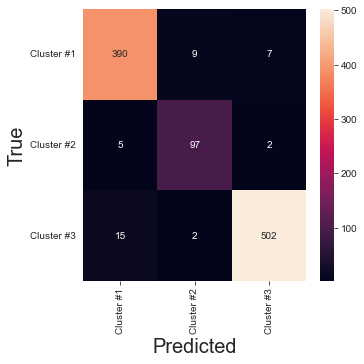

In [45]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_targs, np.argmax(preds,axis=-1))
## Get Class Labels
class_names = ["Cluster #1","Cluster #2","Cluster #3"]
#class_names = ["<40","40-60","60-80",">80"]
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()
ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)
plt.savefig("./Plots/early_df_cm.pdf", bbox_inches="tight")

# sUAS RAA

In [2]:
training_df_raw=pd.read_csv("0.5s_raw_range_range_azimuth_anglev2.csv")

In [5]:
def MFCCCalc(audioData, Fs):
    '''
    Converts decoded wav file to MFCC feature space
    @param audioData: Numpy array of decoded audio wav file
    @return MFCC coefficients
    '''
    #audioData=audioData.numpy()
    data= audioData.astype(float)
    #coefs = mfcc(data, sr=sampleRate, hop_length=2048)
    coefs = mfcc(y=data, hop_length=8000,n_mfcc=40, sr=Fs)
    return coefs
#cluster_3=["Phone_28","Phone_3-5","Phone_3-4","Phone_3-2","Phone_2-5","Phone_5-3","Phone_30","Phone_6-5","Phone_11","Phone_5-2","Phone_9","Phone_7-2"]
cluster_3_TDoA=["Phone_28","Phone_3-4","Phone_3-2","Phone_2-5","Phone_5-3","Phone_30","Phone_6-5","Phone_11","Phone_5-2","Phone_9","Phone_7-2"]

bad_runs=["A3R6P1","A3R4P4","A3R4P5","A3R3P4","A3R3P5"]
good_runs_IF=["A1R1P1","A1R1P2","A1R1P3","A1R1P4","A1R1P5","A2R1P1","A2R1P2","A2R1P3","A2R1P4","A2R1P5","A2R2P1","A2R2P2","A2R2P3","A2R2P4","A2R2P5"]
good_runs_matrice=["A1R2P2","A1R2P3","A1R2P4","A1R2P5","A2R3P1","A2R3P2","A2R4P1","A2R4P2","A2R4P3","A3R3P1","A3R3P2","A3R4P2","A3R4P3","A3R4P5"]
good_runs_phantom=["A2R5P1","A2R5P2","A2R5P3","A2R5P4","A2R5P5","A2R6P1","A2R6P2","A2R6P3","A2R6P4","A2R6P5","A3R5P1","A3R5P2","A3R5P3","A3R5P4","A3R6P1","A3R6P2","A3R6P3","A3R6P4"]
test_runs_matrice=["A2R3P3","A3R3P3"]
notable_col_names=['Pass','Segment','Phone','Lat','Lon','Alt','Range']
passes_df=pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\A1_A2_A3_flight_directory.csv")
x_data=[]
y_data=[]
def melspect(audioData, Fs):
    '''
    Converts decoded wav file to MFCC feature space
    @param audioData: Numpy array of decoded audio wav file
    @return MFCC coefficients
    '''
    data= audioData.astype(float)
    # spect = melspectrogram(y=data,sr=Fs, hop_length=1024,n_mels=64, n_fft=2048)
    spect = melspectrogram(y=data,sr=Fs)
    return spect
def phaseSpect(audioData, Fs):
    '''
    Converts decoded wav file to MFCC feature space
    @param audioData: Numpy array of decoded audio wav file
    @return MFCC coefficients
    '''
    data= audioData.astype(float)
    # spect = melspectrogram(y=data,sr=Fs, hop_length=1024,n_mels=64, n_fft=2048)
    x_=np.squeeze(audioData)
    spect = signal.spectrogram(x=x_,fs=Fs,mode='complex')
    return spect[2]

def TDoA(y1, y2, sr):
    y1_=np.squeeze(y1)/1000
    y2_=np.squeeze(y2)/1000
    # print(len(y1_),len(y2_))
    n = len(y1_)
    corr = signal.correlate(y2_, y1_, mode='same') / np.sqrt(signal.correlate(y1_, y1_, mode='same')[int(n/2)] * signal.correlate(y2_, y2_, mode='same')[int(n/2)])
    delay_arr = np.linspace(-0.5*n/sr, 0.5*n/sr, n)
    delay = delay_arr[np.argmax(corr)]
    return delay

x_data=[]
angle_data=[]
range_data=[]
azimuth_data=[]
thd_frame=[]
range_frame=[]
for x in passes_df.iterrows():
    row=x[1]
    pass_num=row[0]
    scenario=row[1]
    run_num=row[2]
    start=row[3]
    stop=row[4]
    if scenario != "A1":
        drone_gps_file=row[5]
        full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
        pass_df=training_df_raw.loc[training_df_raw[str(notable_col_names.index('Pass'))] == full_name]
        #pass_df=training_df.loc[training_df["Pass"] == full_name]
        max_segment=pass_df[str(notable_col_names.index('Segment'))].max()
        #max_segment=pass_df["Segment"].max()
        #for i in range(0,max_segment):
        print(full_name)
        if full_name in good_runs_IF:
            drone_type=1
        elif full_name in good_runs_matrice:
            drone_type=0
        else:
            drone_type=2
        if full_name in good_runs_matrice or full_name in good_runs_IF or full_name in good_runs_phantom:
        #if full_name in good_runs_phantom:
            for i in range(0,max_segment):
                clust_3=[]
                frame_df=pass_df.loc[pass_df[str(notable_col_names.index('Segment'))]==i]
                if len(frame_df != 0):
                    range_dist=frame_df.iloc[0][7]
                    angle=frame_df.iloc[0][8]
                    azimuth=frame_df.iloc[0][9]
                    thd_frame=[]
                    range_frame=[]
                    # reference_data=np.array(frame_df.loc[frame_df[str(notable_col_names.index('Phone'))]=='Phone_3-5'].iloc[:,10:4010])
                    for phone in cluster_3:
                        # if phone in cluster_1:
                        #     cluster=1
                        # elif phone in cluster_2:
                        #     cluster=2
                        # elif phone in cluster_3:
                        #     cluster=3
                    #for i in range(0,max_segment):
                        #frame_df=phone_seg.loc[phone_seg[str(notable_col_names.index('Segment'))]==i]
                        phone_seg=frame_df.loc[frame_df[str(notable_col_names.index('Phone'))]==phone]
                    #phone_seg=frame_df.loc[frame_df["Name"]==phone]
                        data=np.array(phone_seg.iloc[:,10:4010])
                        if np.any(data):
                            mel_data=phaseSpect(data,8000)
                        else:
                            mel_data=np.zeros((129,17))
                            #mel_data=0
                        thd_frame.append(mel_data)
                    if range_dist<200:
                        x_data.append(np.array(thd_frame))
                        range_data.append(range_dist)
                        angle_data.append(angle)
                        azimuth_data.append(azimuth)

A2R1P1
A2R1P2
A2R1P3
A2R1P4
A2R1P5
A2R2P1
A2R2P2
A2R2P3
A2R2P4
A2R2P5
A2R3P1
A2R3P2
A2R3P3
A2R4P1
A2R4P2
A2R4P3
A2R5P1
A2R5P2
A2R5P3
A2R5P4
A2R5P5
A2R6P1
A2R6P2
A2R6P3
A2R6P4
A2R6P5
A2R7P1
A2R7P2
A2R7P3
A2R7P4
A2R7P5
A2R8P1
A2R8P2
A2R8P3
A2R8P4
A2R8P5
A3R3P1
A3R3P2
A3R3P3
A3R3P4
A3R3P5
A3R4P1
A3R4P2
A3R4P3
A3R4P4
A3R4P5
A3R5P1
A3R5P2
A3R5P3
A3R5P4
A3R6P1
A3R6P2
A3R6P3
A3R6P4


In [89]:
def subsample(x_data,y_data):
    new_x=[]
    new_y=[]
    rng=np.random.default_rng(12345)
    for x in range(len(x_data)):
        rand_vals=rng.integers(low=1,high=5,size=1)
        if -10<y_data[x]<0 and rand_vals==2:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
        elif not -10<y_data[x]<0:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
    return np.array(new_x), np.array(new_y)
new_x,new_y=subsample(x_data,azimuth_data)

(array([ 55., 200., 383.,  79.,  55.,  52.,  45.,  39.,  42.,  42.,  31.,
         43.,  33.,  35.,  40.,  30.,  40.,  24.,  45.,  30.,  34.,  34.,
         31.,  40.,  34.,  29.,  36.,  30.,  34.,  34.,  29.,  38.,  29.,
         37.,  28.,  34.,  31.,  32.,  42.,  31.,  35.,  36.,  33.,  43.,
         58., 105.,  21.,  21.,  23.,  23.]),
 array([ 29.43198211,  32.84210493,  36.25222775,  39.66235057,
         43.07247339,  46.4825962 ,  49.89271902,  53.30284184,
         56.71296466,  60.12308748,  63.5332103 ,  66.94333312,
         70.35345593,  73.76357875,  77.17370157,  80.58382439,
         83.99394721,  87.40407003,  90.81419285,  94.22431566,
         97.63443848, 101.0445613 , 104.45468412, 107.86480694,
        111.27492976, 114.68505258, 118.09517539, 121.50529821,
        124.91542103, 128.32554385, 131.73566667, 135.14578949,
        138.55591231, 141.96603512, 145.37615794, 148.78628076,
        152.19640358, 155.6065264 , 159.01664922, 162.42677204,
        165.836894

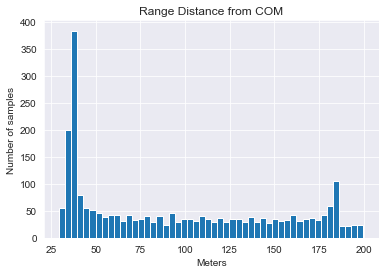

In [13]:
#new_azimuth=np.array(np.array(azimuth_data)>0, dtype=int)
plt.title("Range Distance from COM")
plt.xlabel("Meters")
plt.ylabel("Number of samples")
plt.hist(range_data,bins=50)

In [91]:
modelCNN_MCV2=tf.keras.Sequential()
modelCNN_MCV2.add(BatchNormalization(input_shape=(12,129,17,1)))
modelCNN_MCV2.add(Conv2D(filters=8,kernel_size=(4,4),strides=(1,1),padding='SAME', use_bias=False, name='conv_1'))
modelCNN_MCV2.add(BatchNormalization())
modelCNN_MCV2.add(Activation('relu'))
modelCNN_MCV2.add(MaxPooling3D(2))
modelCNN_MCV2.add(Conv2D(filters=16,kernel_size=(2,2),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_2'))
modelCNN_MCV2.add(BatchNormalization())
modelCNN_MCV2.add(Activation('relu'))
modelCNN_MCV2.add(Dropout(0.3))
modelCNN_MCV2.add(Conv2D(filters=32,kernel_size=(2,2),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_3'))
modelCNN_MCV2.add(BatchNormalization())
modelCNN_MCV2.add(Activation('relu'))
modelCNN_MCV2.add(Dropout(0.3))
modelCNN_MCV2.add(Flatten())
modelCNN_MCV2.add(Dense(512, activation='relu', name='dense_2'))
modelCNN_MCV2.add(Dense(256, activation='relu', name='dense_3'))
modelCNN_MCV2.add(Dropout(0.5))
modelCNN_MCV2.add(Dense(1, activation='sigmoid', name='output_range'))
optimizer= tf.keras.optimizers.Adam()
modelCNN_MCV2.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])


reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 verbose=1, patience=20, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=40, mode='auto', restore_best_weights=True)
modelCNN_MCV2.build(input_shape=(12,129,17,1))
modelCNN_MCV2.summary()
x_train=np.array(x_data)
y_train=np.array(new_azimuth)
history = modelCNN_MCV2.fit(x_train, y_train,
                      epochs=200,
                      batch_size=32,
                      shuffle=True,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_53 (Bat  (None, 12, 129, 17, 1)   4         
 chNormalization)                                                
                                                                 
 conv_1 (Conv2D)             (None, 12, 129, 17, 8)    128       
                                                                 
 batch_normalization_54 (Bat  (None, 12, 129, 17, 8)   32        
 chNormalization)                                                
                                                                 
 activation_39 (Activation)  (None, 12, 129, 17, 8)    0         
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 6, 64, 8, 8)      0         
 3D)                                                             
                                                     

(array([117.,  90.,  82.,  62.,  53.,  53.,  44.,  55., 342.,  54.,  31.,
         28.,  23.,  27.,  18.,  21.,  12.,  18.,  17.,  12.,  14.,  17.,
         14.,  17.,  16.,  19.,  11.,  16.,  12.,  12.,  17.,  13.,  16.,
         17.,  17.,  18.,  19.,  23.,  24.,  19.,  32.,  24.,  27.,  32.,
         37.,  47.,  51.,  54.,  67.,  82.]),
 array([  2.983643  ,   5.73107237,   8.47850173,  11.2259311 ,
         13.97336047,  16.72078984,  19.46821921,  22.21564858,
         24.96307795,  27.71050732,  30.45793669,  33.20536605,
         35.95279542,  38.70022479,  41.44765416,  44.19508353,
         46.9425129 ,  49.68994227,  52.43737164,  55.18480101,
         57.93223038,  60.67965974,  63.42708911,  66.17451848,
         68.92194785,  71.66937722,  74.41680659,  77.16423596,
         79.91166533,  82.6590947 ,  85.40652406,  88.15395343,
         90.9013828 ,  93.64881217,  96.39624154,  99.14367091,
        101.89110028, 104.63852965, 107.38595902, 110.13338839,
        112.880817

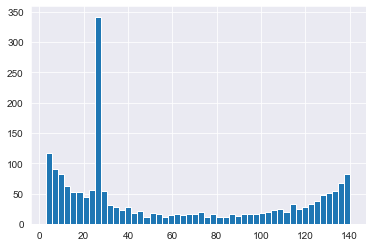

In [6]:
from scipy import stats
plt.hist(y_train+30,bins=50)